[Audio Normal] RR estimate: 27.16 bpm, Resp band energy: 0.0017
[Audio Wheeze] RR estimate: 29.99 bpm, Resp band energy: 0.0350
[IMU] RR estimate: 17.14 bpm (from filtered accel)
[Fusion] Fused RR: 23.72 bpm, Posterior P: 0.0476
[Cough model] Trained RandomForest, test F1 score: 0.000


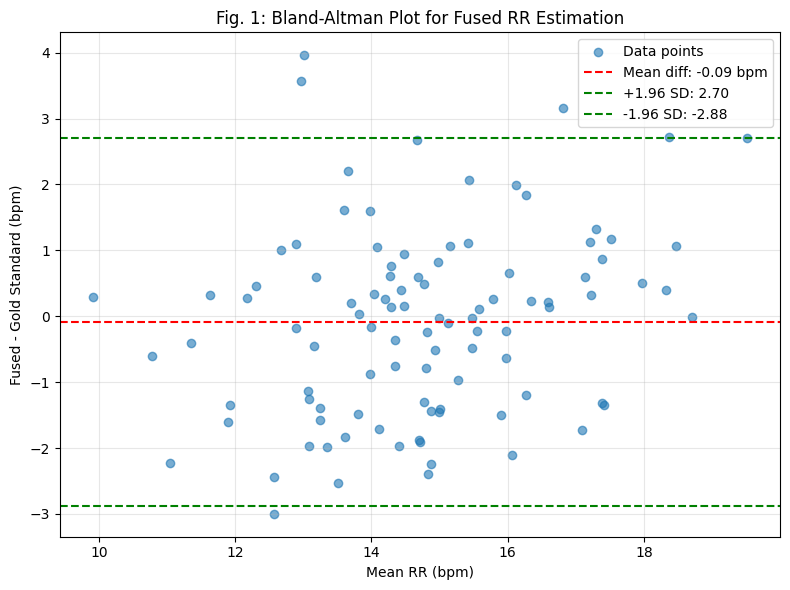

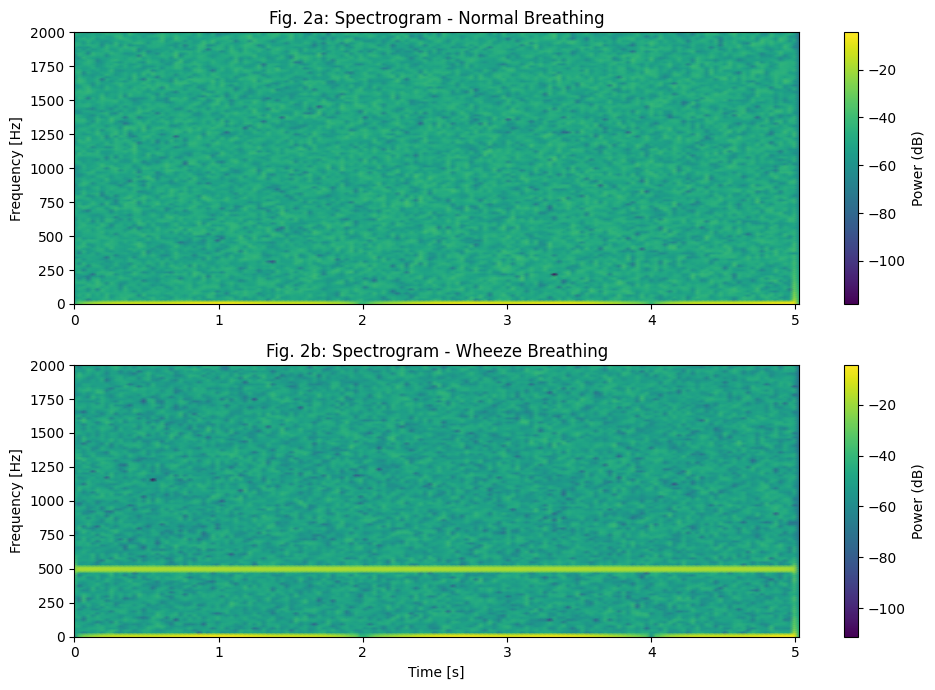

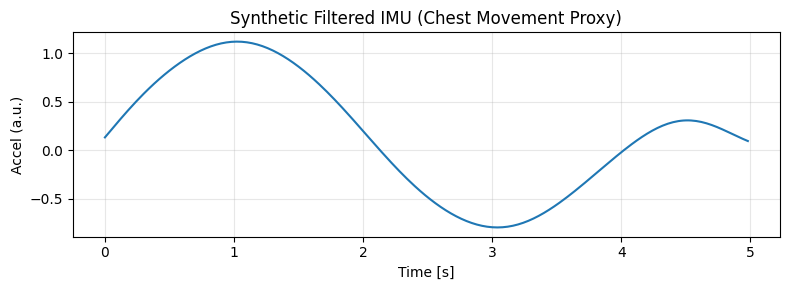

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# -------------------------
# Synthetic data & feature functions
# -------------------------

def generate_synthetic_audio(duration=5, fs=16000, rr=15, noise_level=0.1, wheeze=False):
    """
    Generate synthetic breath audio with optional wheeze.
    - duration: seconds
    - fs: sampling rate
    - rr: true respiratory rate (bpm)
    - noise_level: std dev of Gaussian noise
    - wheeze: add ~500 Hz tone if True
    """
    t = np.linspace(0, duration, int(fs * duration), endpoint=False)
    # Fundamental respiratory frequency (Hz)
    f_rr = rr / 60.0
    # Simple sinusoidal envelope for breath sounds + slight modulation for realism
    breath_envelope = np.sin(2 * np.pi * f_rr * t)
    breath = 0.5 * breath_envelope * (1 + 0.2 * np.sin(2 * np.pi * 5 * f_rr * t))
    noise = noise_level * np.random.normal(0, 1, len(t))
    audio = breath + noise

    if wheeze:
        # Add wheeze tone (around 500 Hz)
        f_wheeze = 500.0
        audio += 0.3 * np.sin(2 * np.pi * f_wheeze * t)

    return audio, t


def stft_features(audio, fs=16000):
    """
    Compute STFT-based features and an autocorrelation RR estimate.
    Returns:
      - rr_est: estimated respiratory rate (bpm)
      - energy_resp: average energy in respiratory band (200-2000 Hz)
    """
    # High-pass filter (100 Hz cutoff) to remove DC/low-frequency drifts
    b_hp, a_hp = signal.butter(4, 100, btype='high', fs=fs)
    audio_filt = signal.filtfilt(b_hp, a_hp, audio)

    # STFT for energy (spectral domain)
    f, t_stft, Zxx = signal.stft(audio_filt, fs=fs, nperseg=1024, noverlap=512, window='hann')
    # Respiratory band (200-2000 Hz)
    resp_mask = (f >= 200) & (f <= 2000)
    # Protect against empty mask
    if np.any(resp_mask):
        energy_resp = np.sum(np.abs(Zxx[resp_mask, :]) ** 2, axis=0).mean()
    else:
        energy_resp = 0.0

    # Autocorrelation for periodicity-based RR (on filtered audio)
    autocorr = np.correlate(audio_filt, audio_filt, mode='full')
    autocorr = autocorr[len(autocorr) // 2 :]  # keep positive lags

    # Minimum allowable distance between peaks (samples) -> corresponds to 30 bpm max => 2 s
    distance_min = int(fs * (60.0 / 30.0))  # = fs * 2 seconds
    # Use a small epsilon for prominence threshold
    prom = max(np.std(autocorr) * 0.5, 1e-6)
    peaks, _ = signal.find_peaks(autocorr, distance=distance_min, prominence=prom)

    if len(peaks) > 1:
        peak_intervals = np.diff(peaks) / fs  # seconds between peaks
        mean_interval = np.mean(peak_intervals)
        if mean_interval > 0:
            rr_est = 60.0 / mean_interval
        else:
            rr_est = 15.0
    else:
        rr_est = 15.0  # fallback

    return rr_est, energy_resp


def generate_synthetic_imu(duration=5, fs=50, rr=15):
    """
    Generate synthetic vertical acceleration for chest movement.
    - Bandpass 0.1-1 Hz for respiratory signal.
    Returns:
      - rr_est: estimated respiratory rate from IMU (bpm)
      - accel_z_filt: filtered acceleration waveform
      - t_imu: time vector
    """
    t_imu = np.linspace(0, duration, int(fs * duration), endpoint=False)
    f_rr = rr / 60.0
    accel_z = np.sin(2 * np.pi * f_rr * t_imu) + 0.05 * np.random.normal(0, 1, len(t_imu))

    # Bandpass filter to isolate respiratory band (0.1 - 1 Hz)
    b_bp, a_bp = signal.butter(4, [0.1, 1.0], btype='band', fs=fs)
    accel_z_filt = signal.filtfilt(b_bp, a_bp, accel_z)

    # Peak detection for RR estimation from IMU
    distance_min = int(fs * (60.0 / 30.0))  # ~2s minimum interval in samples
    # Use a modest height threshold relative to signal std
    height_thr = 0.1
    peaks, _ = signal.find_peaks(accel_z_filt, distance=distance_min, height=height_thr)

    if len(peaks) > 1:
        peak_intervals = np.diff(peaks) / fs
        mean_interval = np.mean(peak_intervals)
        rr_est = 60.0 / mean_interval if mean_interval > 0 else 15.0
    else:
        rr_est = 15.0

    return rr_est, accel_z_filt, t_imu


def simple_kalman_fusion(rr_audio, rr_imu, prev_fused=15.0, dt=1.0):
    """
    Simplified scalar Kalman filter for RR fusion (audio weighted 0.7 by measurement mixture).
    State is scalar RR, model is persistence (x_k = x_{k-1}).
    Returns x_fused, P_fused.
    """
    # Prediction (persistence)
    x_pred = prev_fused
    P_pred = 1.0 + 0.01  # predicted variance (process noise added)

    # Measurement: take a convex combination (this simulates measurement pre-processing)
    z = 0.7 * rr_audio + 0.3 * rr_imu
    R = 0.05  # measurement noise variance (tunable)

    # Kalman gain & update
    K = P_pred / (P_pred + R)
    x_fused = x_pred + K * (z - x_pred)
    P_fused = (1 - K) * P_pred

    return x_fused, P_fused


# -------------------------
# Dummy cough detection model (illustration)
# -------------------------
def train_cough_model(random_state=42):
    """
    Train a toy RandomForest cough detector on synthetic MFCC-like features.
    Returns the trained classifier and test F1 score.
    """
    np.random.seed(random_state)
    n_samples = 200
    X = np.random.randn(n_samples, 13)  # synthetic MFCC vectors
    y = np.random.choice([0, 1], n_samples, p=[0.8, 0.2])  # 20% coughs

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

    clf = RandomForestClassifier(n_estimators=100, random_state=random_state)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    return clf, f1


# -------------------------
# Plotting / figure generation
# -------------------------
def generate_figures():
    """Generate Fig 1 (Bland-Altman) and Fig 2 (Spectrograms) and save them."""
    # ---------- Fig 1: Bland-Altman ----------
    np.random.seed(42)
    rr_true = np.random.normal(15, 2, 100)  # gold standard
    rr_fused = rr_true + np.random.normal(-0.12, 1.5, 100)  # fused estimates with some error
    mean_rr = (rr_true + rr_fused) / 2.0
    diff_rr = rr_fused - rr_true

    plt.figure(figsize=(8, 6))
    plt.scatter(mean_rr, diff_rr, alpha=0.6, label="Data points")
    mean_diff = np.mean(diff_rr)
    std_diff = np.std(diff_rr)
    plt.axhline(mean_diff, color='red', linestyle='--', label=f"Mean diff: {mean_diff:.2f} bpm")
    loa_upper = mean_diff + 1.96 * std_diff
    loa_lower = mean_diff - 1.96 * std_diff
    plt.axhline(loa_upper, color='green', linestyle='--', label=f"+1.96 SD: {loa_upper:.2f}")
    plt.axhline(loa_lower, color='green', linestyle='--', label=f"-1.96 SD: {loa_lower:.2f}")
    plt.xlabel("Mean RR (bpm)")
    plt.ylabel("Fused - Gold Standard (bpm)")
    plt.title("Fig. 1: Bland-Altman Plot for Fused RR Estimation")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig("bland_altman.png", dpi=300)
    plt.show()

    # ---------- Fig 2: Spectrograms ----------
    audio_normal, _ = generate_synthetic_audio(duration=5, wheeze=False)
    audio_wheeze, _ = generate_synthetic_audio(duration=5, wheeze=True)

    plt.figure(figsize=(10, 7))

    # Normal breathing spectrogram
    plt.subplot(2, 1, 1)
    f_n, t_n, Zxx_n = signal.stft(audio_normal, fs=16000, nperseg=1024, noverlap=512)
    power_db_n = 10.0 * np.log10(np.abs(Zxx_n) ** 2 + 1e-12)  # avoid log(0)
    plt.pcolormesh(t_n, f_n, power_db_n, shading='gouraud')
    plt.title("Fig. 2a: Spectrogram - Normal Breathing")
    plt.ylabel("Frequency [Hz]")
    plt.ylim(0, 2000)
    plt.colorbar(label="Power (dB)")

    # Wheeze breathing spectrogram
    plt.subplot(2, 1, 2)
    f_w, t_w, Zxx_w = signal.stft(audio_wheeze, fs=16000, nperseg=1024, noverlap=512)
    power_db_w = 10.0 * np.log10(np.abs(Zxx_w) ** 2 + 1e-12)
    plt.pcolormesh(t_w, f_w, power_db_w, shading='gouraud')
    plt.title("Fig. 2b: Spectrogram - Wheeze Breathing")
    plt.xlabel("Time [s]")
    plt.ylabel("Frequency [Hz]")
    plt.ylim(0, 2000)
    plt.colorbar(label="Power (dB)")

    plt.tight_layout()
    plt.savefig("spectrograms.png", dpi=300)
    plt.show()


# -------------------------
# Main demo to run components
# -------------------------
if __name__ == "__main__":
    # 1) Generate a normal and wheeze audio, compute STFT features
    audio_n, t_n = generate_synthetic_audio(duration=5, rr=15, wheeze=False)
    rr_audio_n, energy_n = stft_features(audio_n, fs=16000)
    print(f"[Audio Normal] RR estimate: {rr_audio_n:.2f} bpm, Resp band energy: {energy_n:.4f}")

    audio_w, t_w = generate_synthetic_audio(duration=5, rr=18, wheeze=True)
    rr_audio_w, energy_w = stft_features(audio_w, fs=16000)
    print(f"[Audio Wheeze] RR estimate: {rr_audio_w:.2f} bpm, Resp band energy: {energy_w:.4f}")

    # 2) Generate synthetic IMU and estimate RR from it
    rr_imu, accel_z, t_imu = generate_synthetic_imu(duration=5, fs=50, rr=15)
    print(f"[IMU] RR estimate: {rr_imu:.2f} bpm (from filtered accel)")

    # 3) Perform simple fusion with Kalman-like update
    fused, P = simple_kalman_fusion(rr_audio=rr_audio_n, rr_imu=rr_imu, prev_fused=15.0)
    print(f"[Fusion] Fused RR: {fused:.2f} bpm, Posterior P: {P:.4f}")

    # 4) Train toy cough detection model and report F1
    clf, f1 = train_cough_model()
    print(f"[Cough model] Trained RandomForest, test F1 score: {f1:.3f}")

    # 5) Generate figures saved to disk and shown interactively
    generate_figures()

    # Optional: show a quick plot of filtered IMU waveform for visual check
    plt.figure(figsize=(8, 3))
    plt.plot(t_imu, accel_z, label="Filtered accel_z (respiratory proxy)")
    plt.xlabel("Time [s]")
    plt.ylabel("Accel (a.u.)")
    plt.title("Synthetic Filtered IMU (Chest Movement Proxy)")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
